## BUDOWA MODELU
Autorzy: Patryk Klytta, Szymon Chmielewski, Jakub Sowa

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import dask.dataframe as dd


In [2]:
DATA_DIR = '/kaggle/input/jane-street-real-time-market-data-forecasting'
TRAIN_FILE = os.path.join(DATA_DIR, 'train.parquet')
FEATURES_FILE = os.path.join(DATA_DIR, 'features.csv')
BATCH_SIZE = 100000  
TIME_STEPS = 15  

# Zastosowanie Dask do załadowania danych aby uniknąć nadmiernego zuzycia RAMu
print("Załadowanie danych")
df_dask = dd.read_parquet(TRAIN_FILE)

date_id_filter = random.sample(range(0, 1699), 50)
symbol_id_filter = [k for k in range(0, 39)]

# Filtrowanie danych po 'date_id' oraz 'symbol_id'
filtered_df_dask = df_dask[df_dask['symbol_id'].isin(symbol_id_filter) & df_dask['date_id'].isin(date_id_filter)]

filtered_df = filtered_df_dask.compute()
filtered_df = filtered_df.sort_values(['date_id', 'symbol_id', 'time_id']).reset_index(drop=True)
filtered_df = filtered_df.fillna(0) #brakujące dane zastępowane zerami


Załadowanie danych...


- BATCH_SIZE = 100000 - wykorzystywana do kontrolowania liczby danych przetwarzanych w jednym przebiegu modelu
- TIME_STEPS = 15 - rozmiar okna czasowego, czyli długość sekwencji, na którą model ma patrzeć, pozwala określić, ile danych historycznych jest uwzględnianych przy prognozie (15 kroków czasowych)

Wczytanie train.parquet z wykorzystaniem batchy (partami) pozwala operować na nim bez zużywania zbyt dużej ilości pamięci RAM

In [21]:
#obecnie brak danych z brakującymi wartościami ze względu na uzupełnienie braków w poprzednim kroku
missing_values_sample = filtered_df.isna().sum()
missing_values_filtered = missing_values_sample[missing_values_sample > 0]

if not missing_values_filtered.empty:
    print("Brakujące wartości na podstawie próby:")
    print(missing_values_filtered)
else:
    print("Nie wykryto brakujących wartości w danych.")

# Wizualizacja braków w danych
if len(missing_values_filtered) > 0:
    cols_to_plot = missing_values_filtered.head(50).index
    plt.figure(figsize=(20, 5))
    plt.bar(cols_to_plot, missing_values_filtered[cols_to_plot])
    plt.xticks(rotation=90)
    plt.title('Brakujące wartości')
    plt.show()
else:
    print("Brak wystarczających danych do wizualizacji braków.")


Nie wykryto brakujących wartości w danych.
Brak wystarczających danych do wizualizacji braków.


In [3]:
X, y = [], []
for (date_id, symbol_id), group in filtered_df.groupby(['date_id', 'symbol_id']):
    group = group.sort_values('time_id')
    features = group.filter(like='feature_').values
    target = group['responder_6'].values

    # Tworzymy okna o rozmiarze TIME_STEPS=15
    for i in range(len(features) - TIME_STEPS):
        X.append(features[i:i+TIME_STEPS])
        y.append(target[i+TIME_STEPS])

X, y = np.array(X), np.array(y)

# Podział na zbiory treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X Train shape: {X_train.shape}")
print(f"y Train shape: {y_train.shape}")
print(f"X Test shape: {X_test.shape}")
print(f"y Test shape: {y_test.shape}")

X Train shape: (1059016, 15, 79)
y Train shape: (1059016,)
X Test shape: (264754, 15, 79)
y Test shape: (264754,)


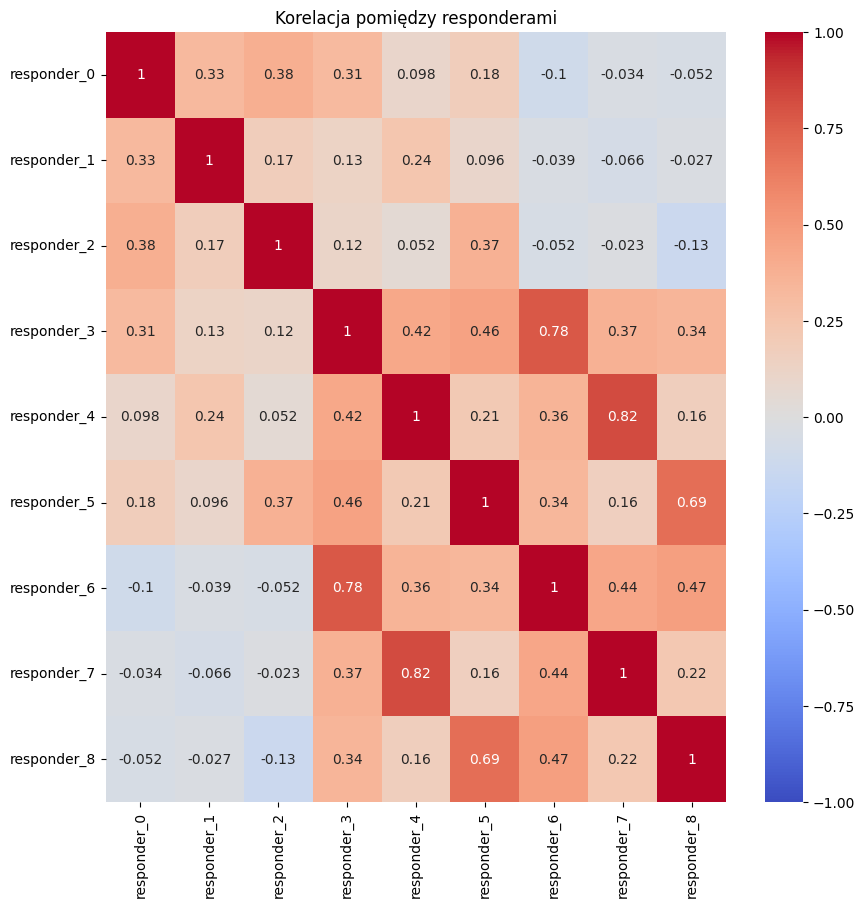

In [23]:
import seaborn as sns

# Analiza korelacji między responderami
responders_columns = [col for col in filtered_df.columns if 'responder' in col]

# Korelacja między responderami
correlation_matrix = filtered_df[responders_columns].corr()

# Heatmapa korelacji
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelacja pomiędzy responderami')
plt.show()



**WYSOKIE KORELACJE** (wzrost jednej zmiennej jest związany ze wzrostem drugiej):
- responder_04 i responder_07 
- responder_03 i responder_06 
- responder_03 i responder_05 
- responder_00 i responder_03 

**UJEMNE KORELACJE** (odwrotna zależność między zmiennymi):
- responder_02 i responder_08 
- responder_01 i responder_07 
- responder_00 i responder_06 

Wnioski:
- należy przyjrzeć sie zmiennym o wysokim poziomie korelacji
- korelacje ujemne nie są zbytnio widoczne stąd analiza zależności odwrotnych może nie występować

In [24]:
# Wyświetlenie macierzy korelacji w formie tekstowej
print("Macierz korelacji między zmiennymi 'responder':")
print(correlation_matrix)

Macierz korelacji między zmiennymi 'responder':
             responder_0  responder_1  responder_2  responder_3  responder_4  \
responder_0     1.000000     0.326256     0.383214     0.313846     0.097870   
responder_1     0.326256     1.000000     0.174240     0.130172     0.236899   
responder_2     0.383214     0.174240     1.000000     0.117045     0.051941   
responder_3     0.313846     0.130172     0.117045     1.000000     0.423833   
responder_4     0.097870     0.236899     0.051941     0.423833     1.000000   
responder_5     0.177729     0.095776     0.369486     0.455016     0.212392   
responder_6    -0.100636    -0.038668    -0.051676     0.778837     0.358819   
responder_7    -0.034246    -0.066078    -0.022617     0.367700     0.822470   
responder_8    -0.051759    -0.026867    -0.128936     0.344290     0.164514   

             responder_5  responder_6  responder_7  responder_8  
responder_0     0.177729    -0.100636    -0.034246    -0.051759  
responder_1     0.0

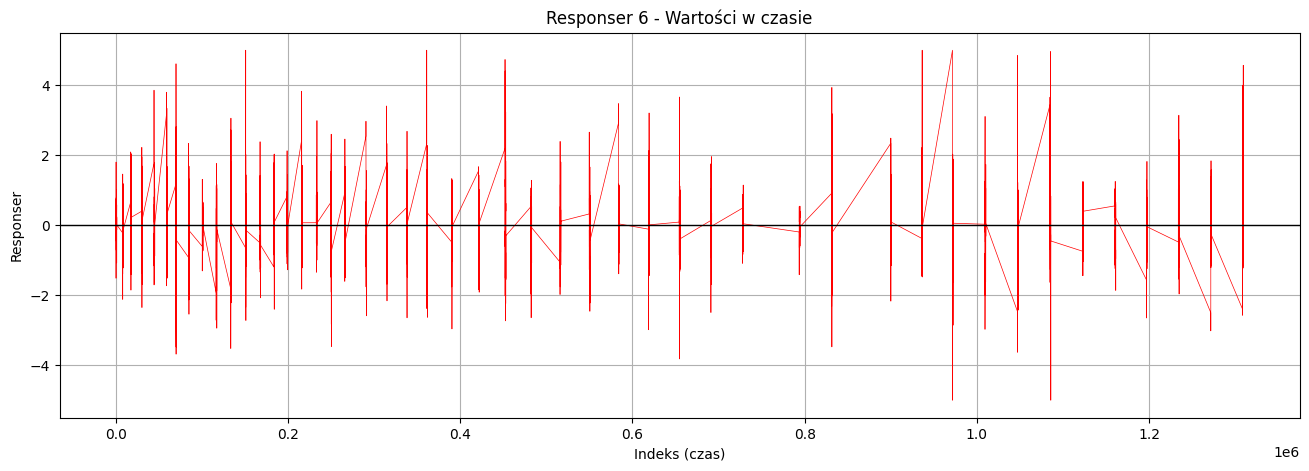

In [26]:
filtered_data = filtered_df[filtered_df['symbol_id'] == 1]  

xx = filtered_data.index
yy = filtered_data['responder_6']

# Wykres Responsera 6 w czasie (po zastąpieniu brakujących wartości zerami)
plt.figure(figsize=(16, 5))
plt.plot(xx, yy, color='red', linewidth=0.5)
plt.title('Responser 6 - Wartości w czasie')
plt.xlabel('Indeks (czas)')
plt.ylabel('Responser')
plt.grid(True)
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.show()

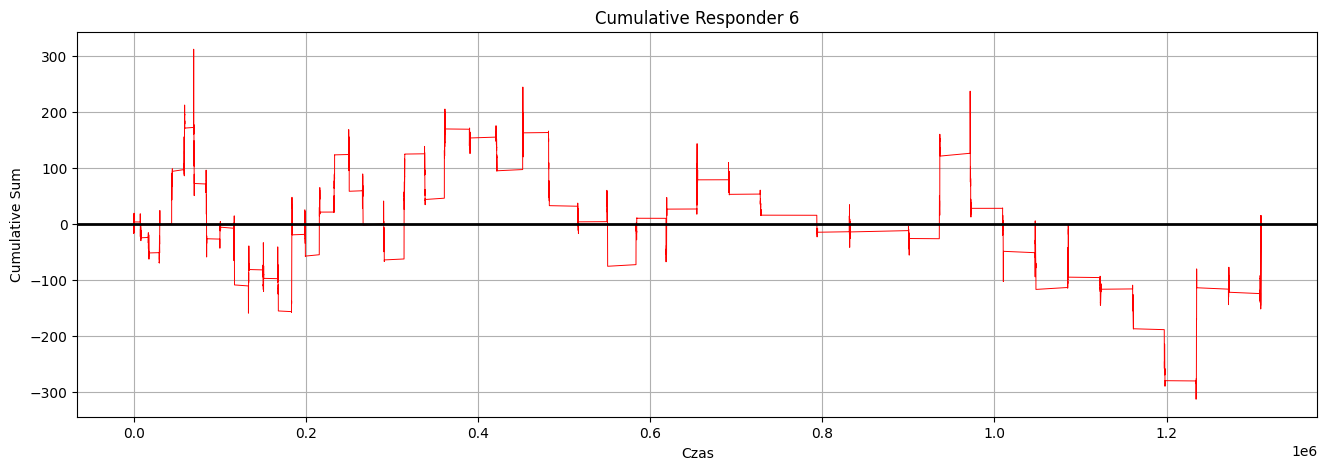

In [27]:
# Wizualizacja skumulowanego Responsera 6 (po zastąpieniu brakujących wartości zerami)
yy_cumsum = yy.cumsum()

plt.figure(figsize=(16, 5))
plt.plot(xx, yy_cumsum, color='red', linewidth=0.7)
plt.title('Cumulative Responder 6')
plt.xlabel('Czas')
plt.ylabel('Cumulative Sum')
plt.axhline(0, color='black', linestyle='-', linewidth=2.0)
plt.grid(True)
plt.show()

PRZYGOTOWANIE MODELU LSTM (Long Short-Term Memory)

Zbudowany model LSTM (sieć neuronowa do analizy danych szeregów czasowych):
- warstwy LSTM -> zapamiętywanie i uzywanie informacji z poprzednich kroków czasowych (64 liczba jednostek, im iwcej tym bardziej złożone zależności w czasie można wykryć; input_shape - forma danych o sekwencji dł.=15, cechy=79)
- Dense : przekształca wektor 64  na 32 wymiary. Aktywacja ReLU pomaga uczyć się nieliniowych zależności w danych jednocześnie może poprawiać stabilność i szybkość uczenia
- Dense(1) -> zwrot pojedynczej wartości

In [4]:
# Tworzenie modelu LSTM
model = Sequential([
    LSTM(64, input_shape=(TIME_STEPS, X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.00001)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

model.compile(optimizer='adam', loss='mse')

# Trening
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=30, batch_size=32, callbacks=[early_stopping, reduce_lr], verbose=2)

# Ocena modelu na zbiorze testowym
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2:.4f}')

# Zapisywanie modelu
model.save("/kaggle/working/LSTM_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
33095/33095 - 363s - 11ms/step - loss: 0.6930 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 2/30
33095/33095 - 334s - 10ms/step - loss: 0.6746 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 3/30
33095/33095 - 328s - 10ms/step - loss: 0.6600 - val_loss: 0.6568 - learning_rate: 0.0010
Epoch 4/30
33095/33095 - 332s - 10ms/step - loss: 0.6476 - val_loss: 0.6462 - learning_rate: 0.0010
Epoch 5/30
33095/33095 - 334s - 10ms/step - loss: 0.6377 - val_loss: 0.6384 - learning_rate: 0.0010
Epoch 6/30
33095/33095 - 337s - 10ms/step - loss: 0.6291 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 7/30
33095/33095 - 328s - 10ms/step - loss: 0.6211 - val_loss: 0.6269 - learning_rate: 0.0010
Epoch 8/30
33095/33095 - 336s - 10ms/step - loss: 0.6136 - val_loss: 0.6195 - learning_rate: 0.0010
Epoch 9/30
33095/33095 - 330s - 10ms/step - loss: 0.6079 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 10/30
33095/33095 - 328s - 10ms/step - loss: 0.6030 - val_loss: 0.6123 - learning_rate: 0.0010

Wnioski:
- Zarówno loss, jak i val_loss (strata na zbiorze walidacyjnym) maleją stopniowo przez cały trening. Jest to pożądana tendencja, ponieważ oznacza, że model staje się coraz lepszy w przewidywaniu na danych treningowych i walidacyjnych
- Wynik R² = 0.1888: oznacza, że model wyjaśnia około 18.88% zmienności zmiennej zależnej (responder_6).
- Wartość R² bliska 0 oznacza, że model nie znajduje znaczących wzorców w danych

Możliwe poprawki w celu osiągnięcia jeszcze lepszej wartości:
- modyfikacja hiperparametrów (liczba jednostek LSTM, warstw Dense, learning rate)
- zwiększyć złożoność modelu poprzez dodanie nowych warstw lub zastosować inne
- poprawa przetwarzania danych a tyczy się to głównie aspektu dodania normalizacji oraz uzupełniania braków danych zerami, które należałoby zastąpić np. uzupełnianiem średnią czy medianą co niestety wiąże się również ze wzrostem zapotrzebowania na zasoby

---------------------------------
Model LSTM, choć skutecznie nauczył się rozpoznawać podstawowe wzorce w danych (redukując stratę w czasie treningu). Wynik R² wynoszący 0.1888 wskazuje na potencjał dalszej poprawy modelu, przez poprawę przetwarzania cech albo optymalizację hiperparametrów.